## Launching Spark

In [1]:
%env SPARK_HOME=/home/ggomarr/.spark
master_node='spark://Otter:7077'
app_name='SparkKMeans'
dataframeMode=True
stopSpark=False

env: SPARK_HOME=/home/ggomarr/.spark


In [2]:
!/home/ggomarr/.spark/sbin/start-master.sh
!/home/ggomarr/.spark/sbin/start-slave.sh {master_node}

org.apache.spark.deploy.master.Master running as process 3733.  Stop it first.
org.apache.spark.deploy.worker.Worker running as process 3793.  Stop it first.


In [3]:
import findspark
findspark.init()

In [4]:
if dataframeMode:
    from pyspark.sql import SparkSession
    spark=SparkSession.builder.master(master_node).appName(app_name).getOrCreate()
    sc=spark.sparkContext
else:
    from pyspark import SparkConf, SparkContext
    conf=SparkConf().setMaster(master_node).setAppName(app_name)
    sc=SparkContext(conf=conf)

## Test using a text file

In [5]:
def process_row(row):
    row=row.strip()
    return [ (len(row),(row)) ] if row else []

file_rows=(sc.textFile("file:///home/ggomarr/.spark/NOTICE")
                      .flatMap(process_row))

for r in file_rows.takeOrdered(5,key=lambda x: -x[0]):
    print(r)

(183, u'(Common Development and Distribution License (CDDL) v1.0) JavaBeans Activation Framework (JAF) (javax.activation:activation:1.1 - http://java.sun.com/products/javabeans/jaf/index.jsp)')
(166, u'(COMMON DEVELOPMENT AND DISTRIBUTION LICENSE (CDDL) Version 1.0) (GNU General Public Library) Streaming API for XML (javax.xml.stream:stax-api:1.0-2 - no url defined)')
(142, u'(CDDL 1.0) Servlet Specification 2.5 API (org.mortbay.jetty:servlet-api-2.5:6.1.14 - http://jetty.mortbay.org/project/modules/servlet-api-2.5)')
(126, u'The following components are provided under the Common Development and Distribution License 1.0. See project link for details.')
(126, u'The following components are provided under the Common Development and Distribution License 1.1. See project link for details.')


## Enjoy

In [6]:
from pyspark.mllib.clustering import KMeans
import matplotlib.pyplot as plt
import numpy as np
import math

In [7]:
def createClusteredData(dimensions,observations,clusters,sigma_div=5):
    if type(sigma_div)!=list:
        sigma_div=[sigma_div]*clusters
    pointsPerCluster = int(1.0*observations/clusters)
    centroids=[]
    xy_lst = []
    label_lst = []
    for cluster in range(clusters):
        centroid = [ np.random.uniform() for dim in range(dimensions) ]        
        centroids.append(np.array(centroid))
        sigma = (np.random.normal()/sigma_div[cluster])**2
        for point in range(pointsPerCluster):
            xy_lst.append([np.random.normal(centroid[dim],sigma) for dim in range(dimensions)])
            label_lst.append(cluster)
    xy_lst = np.array(xy_lst)
    label_lst = np.array(label_lst)
    return (xy_lst,label_lst),centroids

In [8]:
np.random.seed(0)
num_clusters=5
data,originalCentroids=createClusteredData(2,1000,num_clusters,sigma_div=5)
dataRDD=sc.parallelize(data[0])
labelsRDD=sc.parallelize(data[1])

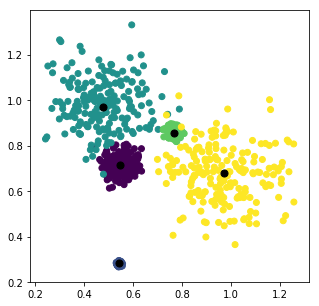

In [9]:
plt.figure(figsize=(5,5))
plt.scatter(data[0][:,0],data[0][:,1],c=data[1].astype(np.float))
plt.scatter([centroid[0] for centroid in originalCentroids],
            [centroid[1] for centroid in originalCentroids],
            marker='o',s=50,c='0')
plt.show()

In [10]:
iterations_lst=[5,5,5,25,25,25,50,50,50,100,100,100]

In [11]:
classifiers=[]
for iterations in iterations_lst:
    classifier=KMeans.train(dataRDD,num_clusters,maxIterations=iterations,initializationMode="random")
    classifiers.append(classifier)

In [12]:
def plotCentroids(data,models,width=3):
    minx,maxx=data[0][:,0].min(),data[0][:,0].max()
    miny,maxy=data[0][:,1].min(),data[0][:,1].max()
    rows=int(math.ceil(1.0*len(models)/width))
    cols=min(len(models),width)
    fig,axes=plt.subplots(rows,cols,sharex=True,sharey=True,figsize=(5*cols, 5*rows))
    if type(axes)!=np.ndarray:
        ax=np.array([axes])
    else:
        axes=axes.flatten()
    for i in range(len(models)):
        centroids=models[i].centers
        axes[i].scatter(data[0][:,0],data[0][:,1],c=data[1].astype(np.float))
        axes[i].scatter([centroid[0] for centroid in centroids],
                        [centroid[1] for centroid in centroids],
                        marker='o',s=50,c='0')
    plt.show()

def error(point,centroid):
    return math.sqrt(sum([x**2 for x in (point-centroid)]))

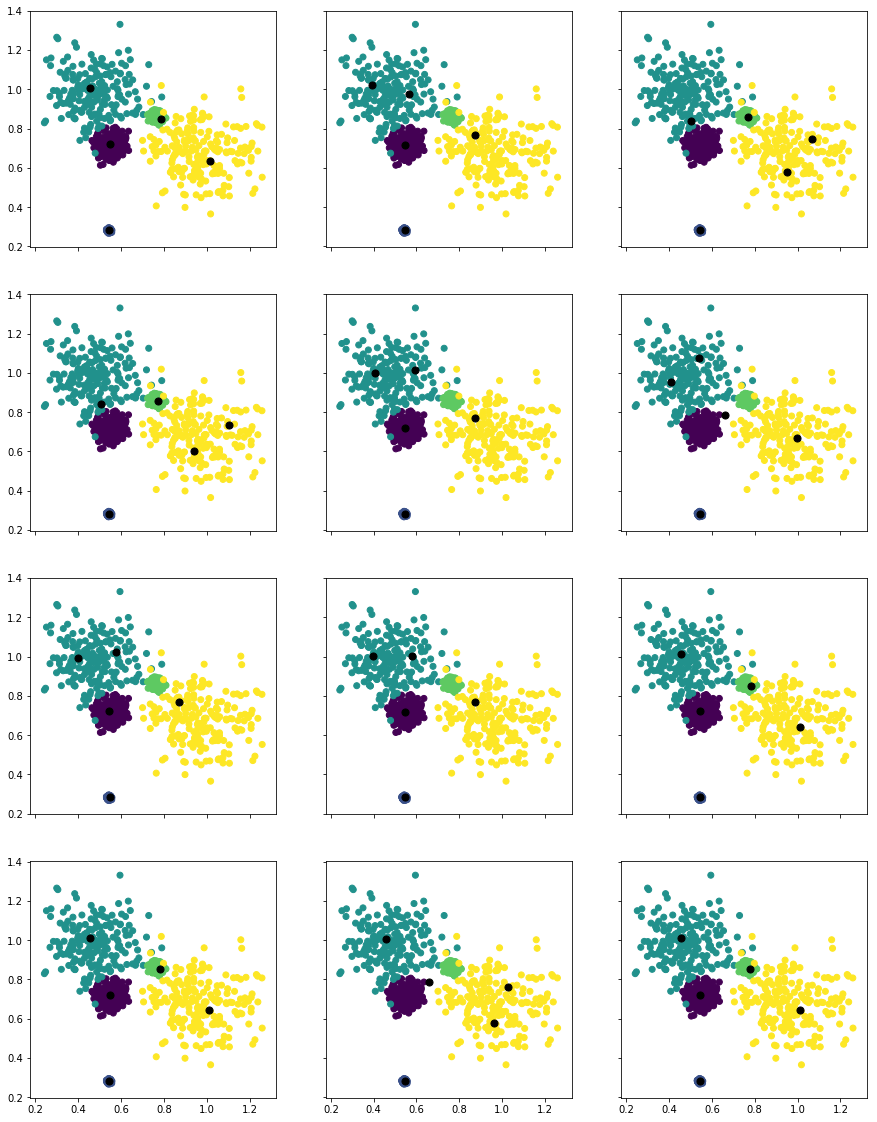

In [13]:
plotCentroids(data,classifiers)

In [14]:
print(labelsRDD.countByValue())

defaultdict(<type 'int'>, {0: 200, 1: 200, 2: 200, 3: 200, 4: 200})


In [15]:
for classifier in classifiers:
    print(dataRDD.map(lambda point: classifier.predict(point)).countByValue())

defaultdict(<type 'int'>, {0: 167, 1: 147, 2: 222, 3: 201, 4: 263})
defaultdict(<type 'int'>, {0: 88, 1: 99, 2: 216, 3: 202, 4: 395})
defaultdict(<type 'int'>, {0: 201, 1: 379, 2: 90, 3: 72, 4: 258})
defaultdict(<type 'int'>, {0: 201, 1: 61, 2: 101, 3: 255, 4: 382})
defaultdict(<type 'int'>, {0: 113, 1: 394, 2: 202, 3: 221, 4: 70})
defaultdict(<type 'int'>, {0: 177, 1: 67, 2: 201, 3: 112, 4: 443})
defaultdict(<type 'int'>, {0: 77, 1: 221, 2: 396, 3: 104, 4: 202})
defaultdict(<type 'int'>, {0: 395, 1: 219, 2: 78, 3: 106, 4: 202})
defaultdict(<type 'int'>, {0: 167, 1: 261, 2: 201, 3: 222, 4: 149})
defaultdict(<type 'int'>, {0: 222, 1: 149, 2: 166, 3: 262, 4: 201})
defaultdict(<type 'int'>, {0: 447, 1: 87, 2: 92, 3: 173, 4: 201})
defaultdict(<type 'int'>, {0: 201, 1: 222, 2: 166, 3: 149, 4: 262})


In [16]:
print((sc.parallelize(zip(data[0],[ originalCentroids[d] for d in data[1] ]))
         .map(lambda x: error(x[0],x[1]))
         .reduce(lambda x, y: x + y)))

72.8149548426


In [17]:
for classifier in classifiers:
    print((dataRDD.map(lambda point: error(point,classifier.centers[classifier.predict(point)]))
                  .reduce(lambda x, y: x + y)))

67.6687111429
98.165380176
93.6729049908
93.6032344361
98.1111074168
105.306999529
98.0268202778
98.0196141697
67.2456248107
67.1905778301
104.102778667
67.1905778301


## Clean up

In [7]:
sc.stop()

In [ ]:
if stopSpark:
    !/home/ggomarr/.spark/sbin/stop-slave.sh
    !/home/ggomarr/.spark/sbin/stop-master.sh